In [ ]:
!pip install -qU eif
import eif

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, RobustScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report

from lightgbm import LGBMClassifier
import lightgbm

from scipy.stats import mannwhitneyu, shapiro, probplot
from scipy.stats import chi2_contingency

from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras import regularizers

In [3]:
np.random.seed(1)
tf.random.set_seed(1)
data_root = r'/content/drive/My Drive/data/card/creditcard.csv'
TARGET_NAME = 'Class'

In [4]:
df = pd.read_csv(data_root)

In [5]:
df.drop_duplicates(inplace=True)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94809.679688,0.005917,-0.004135,0.001615,-0.002965,0.001827,-0.001140,0.001801,-0.000855,-0.001596,-0.001441,0.000200,-0.000714,0.000603,0.000252,0.001042,0.001162,0.000170,0.001515,-0.000264,0.000187,-0.000371,-0.000015,0.000198,0.000214,-0.000233,0.000149,0.001763,0.000547,88.446159,0.001667
std,47480.457031,1.947952,1.646582,1.508639,1.414147,1.376946,1.331881,1.227602,1.178902,1.095429,1.076329,1.018683,0.994619,0.995381,0.952175,0.914856,0.873660,0.842462,0.837337,0.813335,0.769908,0.723856,0.724537,0.623653,0.605583,0.521206,0.482042,0.395686,0.328003,250.354279,0.040796
min,0.000000,-56.407509,-72.715729,-48.325588,-5.683171,-113.743309,-26.160505,-43.557243,-73.216721,-13.434067,-24.588263,-4.797473,-18.683714,-5.791881,-19.214325,-4.498945,-14.129854,-25.162800,-9.498746,-7.213527,-54.497719,-34.830383,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565680,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,-0.535578,-0.761649,-0.406198,-0.647862,-0.425732,-0.581452,-0.466860,-0.483928,-0.498014,-0.456289,-0.211469,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,-0.093237,-0.032306,0.139072,-0.012927,0.050209,0.049299,0.067119,-0.065867,-0.002142,0.003367,-0.062353,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,0.453619,0.739579,0.616976,0.663178,0.492336,0.650104,0.523512,0.398972,0.501956,0.458508,0.133207,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510002,0.000000
max,172792.000000,2.454930,22.057730,9.382559,16.875343,34.801666,73.301628,120.589493,20.007208,15.594995,23.745136,12.018913,7.848392,7.126883,10.526766,8.877742,17.315111,9.253527,5.041069,5.591971,39.420906,27.202839,10.503090,22.528412,4.584549,7.519588,3.517346,31.612198,33.847809,25691.160156,1.000000


In [ ]:
df[TARGET_NAME].value_counts(normalize=True)
# so the desired accuracy is 0.999 or 1.0

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [6]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()
"""
do not forget to use pipeline for cross-validation to prevent data leakage
otherwise sampling and the same scaling would be applied to every fold during cross-validation
"""
def cross_validation(clf, X, y):
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=10, scoring='f1', n_jobs=-1)
    print(f'Меры правильности перекрекстной оценки: {scores}')
    print(f'Точность перекретсной оценки: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
    return scores

def plot_cm_val(y_true, y_pred, X, y, estimator):
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    conf_df = pd.DataFrame(cm, index=[0,1], columns=[0,1])
    scores = np.array(cross_validation(estimator, X, y))
    print('\n')
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    sns.heatmap(conf_df, cmap="Oranges", annot=True, annot_kws={"size": 16}, fmt='d')
    plt.title('Confusion matrix for test')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.subplot(122)
    plt.plot(scores, c='g', linestyle=':', label='Cross Validation Scores', marker='*')
    plt.fill_between(np.arange(scores.shape[0]), scores.mean() - scores.std(), scores.mean() + scores.std(), alpha=0.3)
    plt.axhline(0.5, c='r', linestyle='--', label='min f1_score')
    plt.axhline(scores.mean(), c='b', linestyle='-.', label='score mean')
    plt.legend(loc='best')
    plt.ylim([0.47, max(scores) + 0.1])
    plt.xticks(np.arange(scores.shape[0]))
    plt.grid()
    plt.show()

def report(y_train, y_train_pred, y_test, y_test_pred, y_train_proba=None, y_test_proba=None):
    print('Train\n', classification_report(y_train, y_train_pred, digits=3))
    print('Test\n', classification_report(y_test, y_test_pred, digits=3))
    if y_train_proba is not None and y_test_proba is not None:
        roc_train, roc_test = roc_auc_score(y_train, y_train_proba), roc_auc_score(y_test, y_test_proba)
        print(f'Train ROC_AUC: {roc_train:.3f}, Test ROC_AUC: {roc_test:.3f}')
        print(f'Train GINI: {(2 * roc_train - 1):.3f}, Test GINI: {(2 * roc_test - 1):.3f}')
    print('Confusion Matrix', '\n', pd.crosstab(y_test, y_test_pred))

def custom_oversampling(df, target_name=TARGET_NAME, delimiter=0):
    target_counts = df[target_name].value_counts()
    major_class_name = target_counts.argmax()
    minor_clss_name = target_counts.argmin()
    disbalance_coef = int(target_counts[major_class_name] / target_counts[minor_clss_name]) - 1
    for i in range(disbalance_coef - delimiter):
        sample = df[df[target_name] == minor_clss_name].sample(target_counts[minor_clss_name])
        df = df.append(sample, ignore_index=True)
    return df.sample(frac=1)

def vote(predictions: list, weights: list):
    predictions = np.asarray(predictions).T
    maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=weights)), axis=1, arr=predictions)
    return maj_vote

def reduce_memory(df):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)[:4] != 'uint' and str(col_type) != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif str(col_type)[:4] != 'uint':
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

class AutoEncoder(Model):
    def __init__(self, output_units, reduce_units):
        super().__init__()
        self.encoder = Sequential([
                                   Dense(64, activation='relu'),
                                   Dense(32, activation='relu'),
                                   Dense(16, activation='relu'),
                                   Dense(reduce_units, activation='relu')
        ])
        self.decoder = Sequential([
                                   Dense(16, activation='relu'),
                                   Dense(32, activation='relu'),
                                   Dense(64, activation='relu'),
                                   Dense(output_units, activation='sigmoid')
        ])
    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

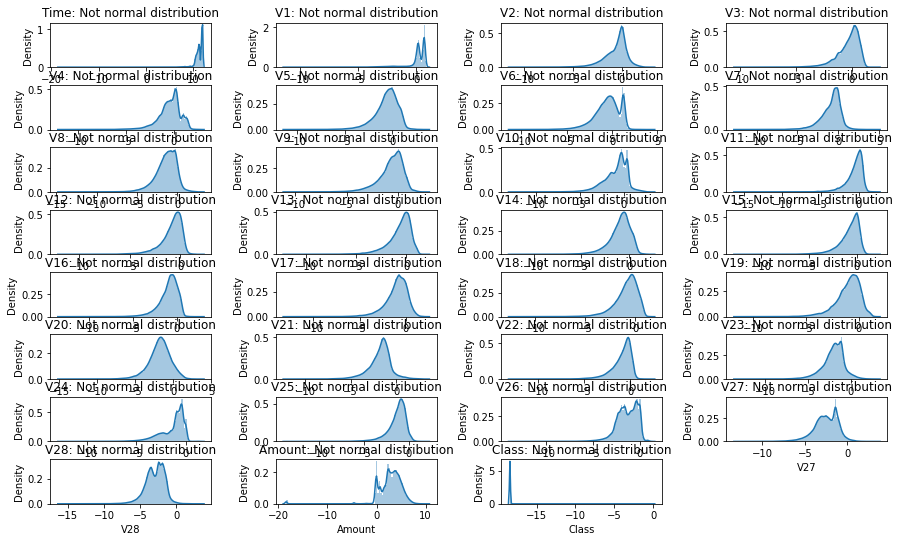

In [ ]:
plt.figure(figsize=(15, 10))
for idx, col in enumerate(df.columns):
    plt.subplot(9, 4, idx + 1)
    dist = 'Normal Distribution' if shapiro(df[col].dropna())[1] > 0.05 else 'Not normal distribution'
    plt.title(f'{col}: {dist}')
    sns.distplot(np.log(df[col]+1e-8), bins=100)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

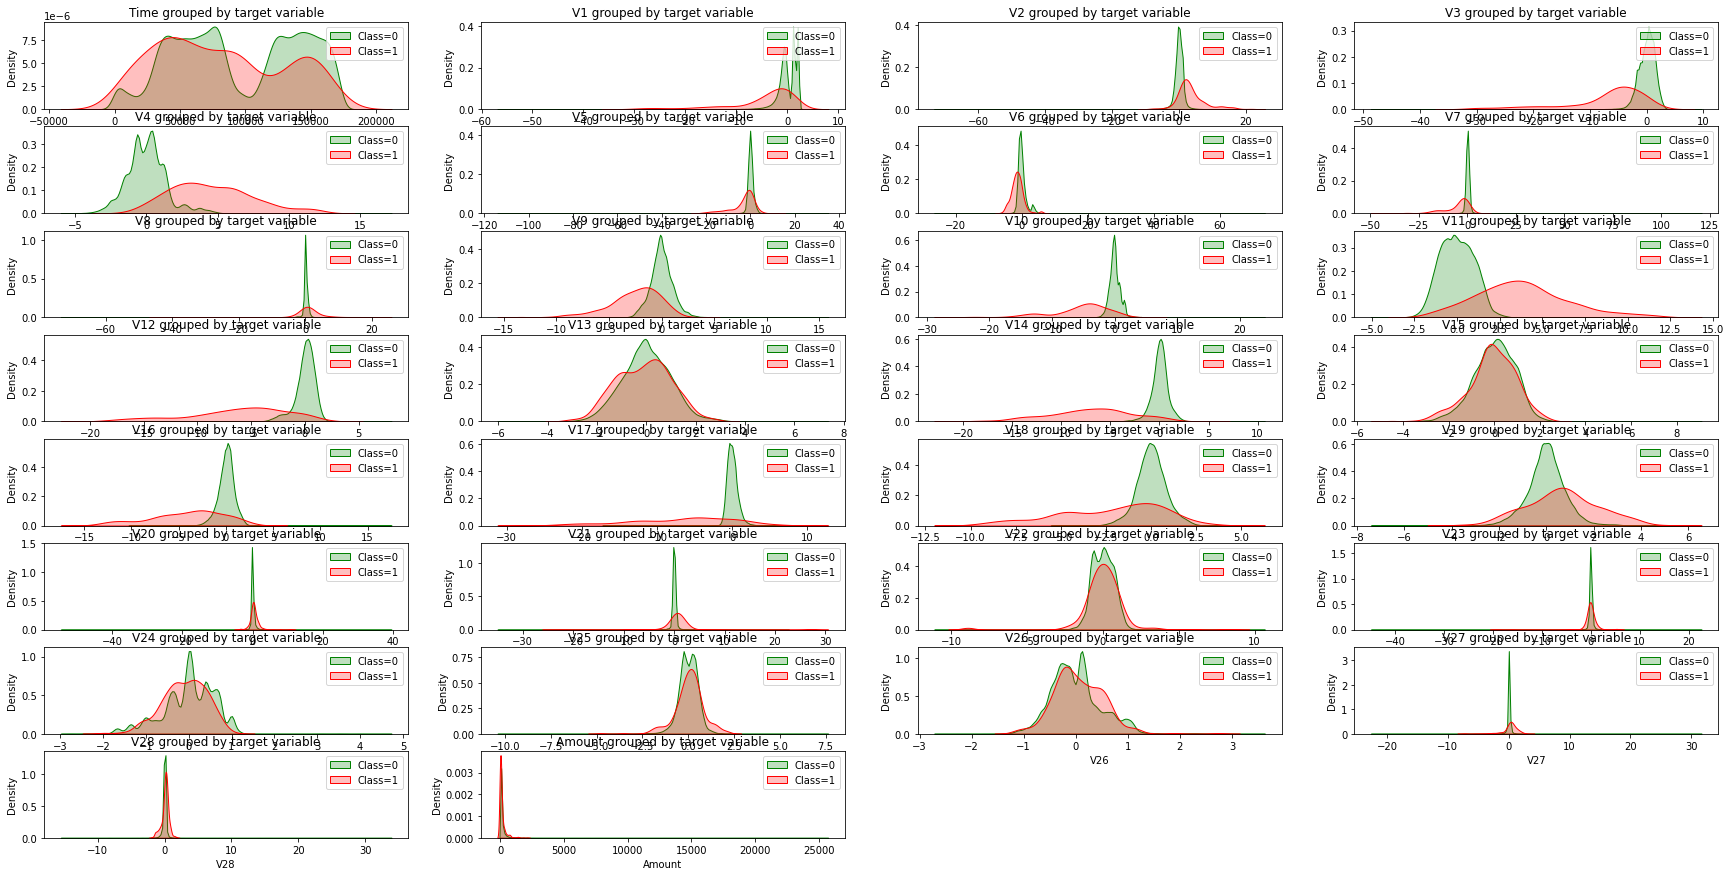

In [ ]:
plt.figure(figsize=(30, 15))
for idx, col in enumerate(df.columns[:-1], 1):
    plt.subplot(8, 4, idx)
    feature_with_target_s = df[[col, TARGET_NAME]]
    feature_s = feature_with_target_s[col]
    feature_target_0 = feature_s[feature_with_target_s[TARGET_NAME] == 0]
    feature_target_1 = feature_s[feature_with_target_s[TARGET_NAME] == 1]

    sns.kdeplot(feature_target_0, shade=True, label='Class=0', color='g')
    sns.kdeplot(feature_target_1, shade=True, label='Class=1', color='r')
    plt.xlabel(col)
    plt.title(f'{col} grouped by target variable')
    plt.legend(loc='best')
plt.show()

In [ ]:
for idx, column in enumerate(df.columns[:-1], 1):
    feature_with_target_s = df[[column, TARGET_NAME]] 
    feature_s = feature_with_target_s[column]
    feature_target_0 = feature_s[feature_with_target_s[TARGET_NAME] == 0]
    feature_target_1 = feature_s[feature_with_target_s[TARGET_NAME] == 1]
    mw = mannwhitneyu(feature_target_0, feature_target_1)
    imp = np.where(mw.pvalue < 0.05, 'usefull', 'useless') 
    if imp == 'usefull' and shapiro(feature_s.dropna())[1] < 0.05:  
        print(f'{idx}) {column}, p-value: {mw.pvalue}, feature is {imp}')
    else:
        print('='*45, f'{mw.pvalue} - {column}')

1) Time, p-value: 2.1930795812041207e-10, feature is usefull
2) V1, p-value: 8.7039235352289e-114, feature is usefull
3) V2, p-value: 8.252188491895332e-164, feature is usefull
4) V3, p-value: 6.055240180580647e-220, feature is usefull
5) V4, p-value: 1.812952218531908e-248, feature is usefull
6) V5, p-value: 1.5268559809207052e-58, feature is usefull
7) V6, p-value: 1.115501235085143e-93, feature is usefull
8) V7, p-value: 7.321168282635339e-147, feature is usefull
9) V8, p-value: 4.254945746414495e-34, feature is usefull
10) V9, p-value: 4.471861693258582e-154, feature is usefull
11) V10, p-value: 4.8055654667415076e-222, feature is usefull
12) V11, p-value: 2.455295915336123e-226, feature is usefull
13) V12, p-value: 4.2080133005902103e-247, feature is usefull
14) V13, p-value: 0.025607405583933023, feature is usefull
15) V14, p-value: 7.357903410397034e-261, feature is usefull
============================================= 0.06475410748912819 - V15
17) V16, p-value: 9.04086141601779

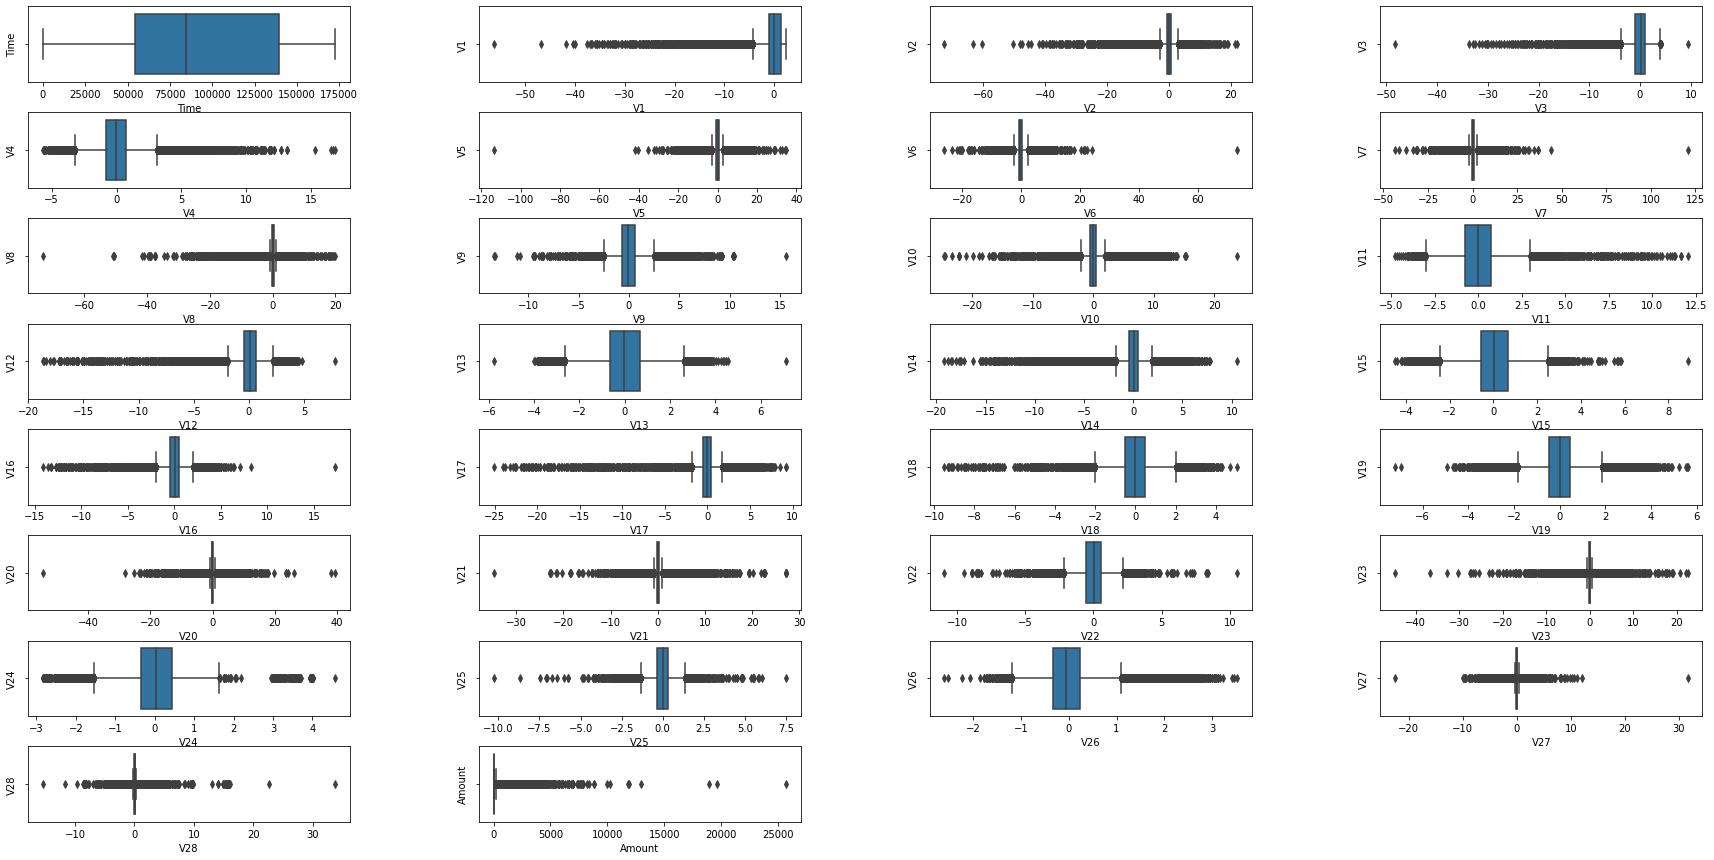

In [ ]:
plt.figure(figsize=(30, 15))
for idx, col in enumerate(df.columns[:-1]):
    plt.subplot(8, 4, idx + 1)
    sns.boxplot(df[col])
    plt.ylabel(col)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()
# think of outliers, we may remove them by IQR or something, but we can loose important information

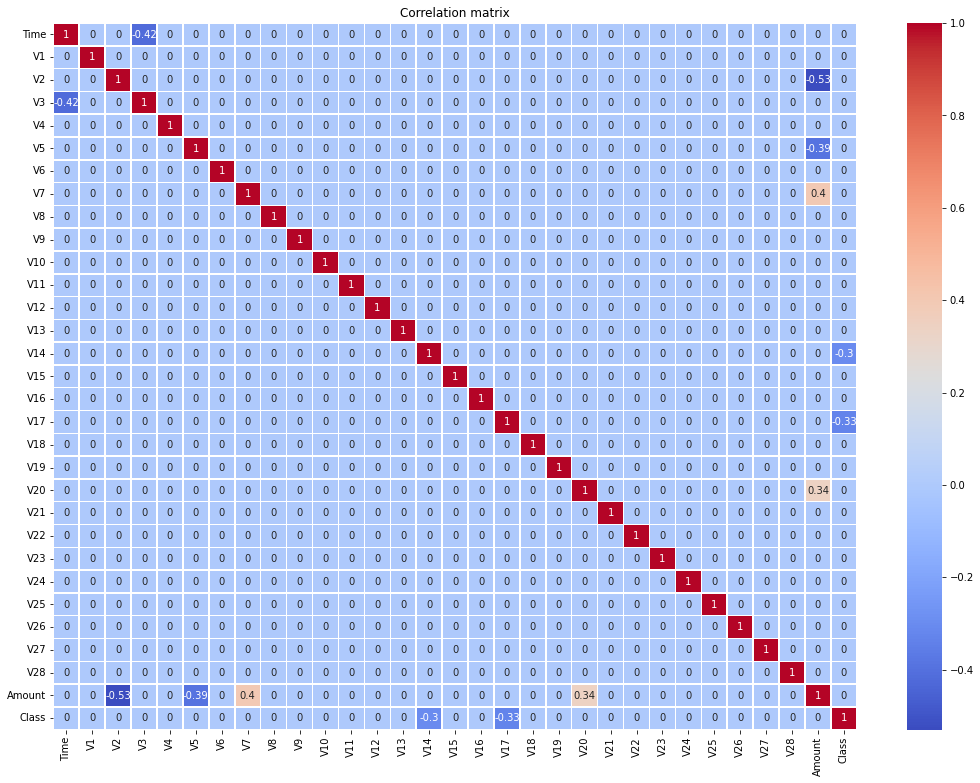

In [ ]:
plt.figure(figsize = (18,13))
corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()
# no correlations

In [7]:
df = reduce_memory(df)

Memory usage of dataframe is 69.27 MB
Memory usage after optimization is: 34.91 MB
Decreased by 49.6%


In [8]:
X, y = df.drop(TARGET_NAME, axis=1), df[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=1)

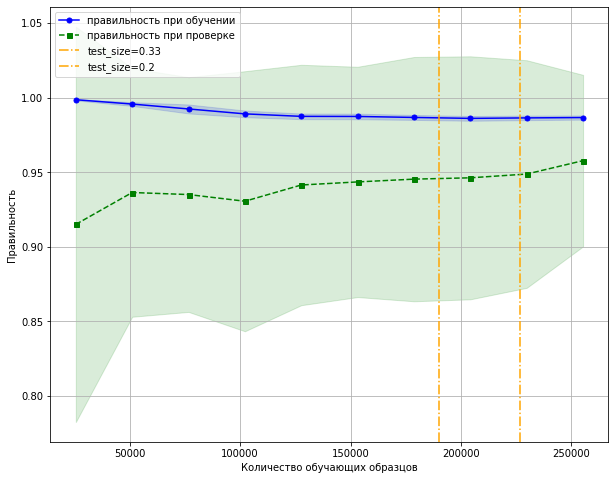

In [ ]:
estimator = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', C=1000.0, tol=1e-4, 
                          max_iter=200, class_weight='balanced'))
train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=X, y=y, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), cv=10, scoring='roc_auc', n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 8))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='правильность при обучении')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
         label='правильность при проверке')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.axvline(X.shape[0]*0.67, color='orange', linestyle='-.', label='test_size=0.33')
plt.axvline(X.shape[0]*0.8, color='orange', linestyle='-.', label='test_size=0.2')
plt.grid()
plt.xlabel('Количество обучающих образцов')
plt.ylabel('Правильность')
plt.legend(loc='best')
plt.show()
# оптимальный test_size=0.2

In [10]:
base = make_pipeline(RobustScaler(), LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', C=100.0, tol=1e-4, 
                     max_iter=200)) # removed class_weight='balanced'
base.fit(X_train, y_train)
base_pred_train = base.predict(X_train)
base_pred_test = base.predict(X_test)
base_train_proba = base.predict_proba(X_train)[:,1]
base_test_proba = base.predict_proba(X_test)[:,1]
report(y_train, base_pred_train, y_test, base_pred_test, base_train_proba, base_test_proba)

Train
               precision    recall  f1-score   support

           0      0.999     1.000     1.000    226602
           1      0.873     0.619     0.724       378

    accuracy                          0.999    226980
   macro avg      0.936     0.809     0.862    226980
weighted avg      0.999     0.999     0.999    226980

Test
               precision    recall  f1-score   support

           0      0.999     1.000     1.000     56651
           1      0.914     0.558     0.693        95

    accuracy                          0.999     56746
   macro avg      0.957     0.779     0.846     56746
weighted avg      0.999     0.999     0.999     56746

Train ROC_AUC: 0.982, Test ROC_AUC: 0.966
Train GINI: 0.964, Test GINI: 0.932
Confusion Matrix 
 col_0      0   1
Class           
0      56646   5
1         42  53


In [ ]:
# so let the task be: minimize recall (FN), as if 0 - good action, identifying bad as good = bad
# identifying good as bad not so critical

0    56651
1       95
Name: Class, dtype: int64

In [11]:
# np.log/np.sqrt transformation, using PowerTranformer is too expensive for resources
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
X_train_scaled, X_test_scaled = np.log(X_train_scaled+1e-5), np.log(X_test_scaled+1e-5)

In [ ]:
# got error on test but on train model not improved

In [ ]:
X_test_scaled[X_test_scaled == np.nan].astype(int).sum()

0

In [12]:
base = LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', C=100.0, tol=1e-4, max_iter=200)
base.fit(X_train_scaled, y_train)
base_pred_train = base.predict(X_train_scaled)
base_pred_test = base.predict(X_test_scaled)
base_train_proba = base.predict_proba(X_train_scaled)[:,1]
base_test_proba = base.predict_proba(X_test_scaled)[:,1]
report(y_train, base_pred_train, y_test, base_pred_test, base_train_proba, base_test_proba)

Train
               precision    recall  f1-score   support

           0      0.999     1.000     1.000    226602
           1      0.868     0.593     0.704       378

    accuracy                          0.999    226980
   macro avg      0.934     0.796     0.852    226980
weighted avg      0.999     0.999     0.999    226980

Test
               precision    recall  f1-score   support

           0      0.999     1.000     0.999     56651
           1      0.860     0.453     0.593        95

    accuracy                          0.999     56746
   macro avg      0.930     0.726     0.796     56746
weighted avg      0.999     0.999     0.999     56746

Train ROC_AUC: 0.978, Test ROC_AUC: 0.967
Train GINI: 0.955, Test GINI: 0.933
Confusion Matrix 
 col_0      0   1
Class           
0      56644   7
1         52  43


In [ ]:
iso = eif.iForest(X.values.astype(np.double), ntrees=100, sample_size=256, ExtensionLevel=X.shape[1]-1)
anomaly_scores = iso.compute_paths(X_in = X.values.astype(np.double))
df['outliers'] = -anomaly_scores
# set q% of outliers, 0 - outlier, 1 - inlier
q = df['outliers'].quantile(q=0.05)
df['outliers'] =  df['outliers'].apply(lambda x: 0 if x<=q else 1)
df['outliers'].value_counts()

1    269536
0     14190
Name: outliers, dtype: int64

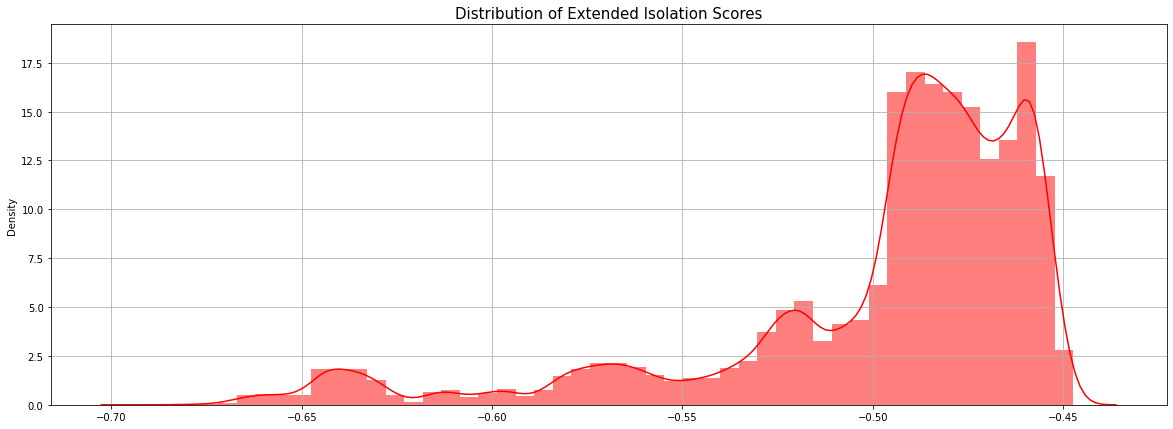

In [ ]:
"""
x1='V28'; x2='V4'
X_inliers = df.loc[df['outliers']==1][[x1,x2]]
X_outliers = df.loc[df['outliers']==0][[x1,x2]]

xx, yy = np.meshgrid(np.linspace(X.iloc[:, 0].min(), X.iloc[:, 0].max(), 50), np.linspace(X.iloc[:, 1].min(), X.iloc[:, 1].max(), 50))

S1 = iso.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S1 = S1.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(30, 7))
plt.title("Extended Isolation Forest Outlier Detection with Outlier Areas", fontsize = 15, loc='center')
levels = np.linspace(np.min(S1),np.max(S1),50)
CS = ax.contourf(xx, yy, S1, levels, cmap=plt.cm.Blues)

inl = plt.scatter(X_inliers.iloc[:, 0], X_inliers.iloc[:, 1], c='white', s=20, edgecolor='k')
outl = plt.scatter(X_outliers.iloc[:, 0], X_outliers.iloc[:, 1], c='red',s=20, edgecolor='k')

plt.axis('tight')
plt.xlim((X.iloc[:, 0].min(), X.iloc[:, 0].max()))
plt.ylim((X.iloc[:, 1].min(), X.iloc[:, 1].max()))
plt.legend([inl, outl],["normal observations", "abnormal observations"],loc="upper left")
plt.show()
"""
fig, ax = plt.subplots(figsize=(20, 7))
ax.set_title('Distribution of Extended Isolation Scores', fontsize = 15, loc='center')
sns.distplot(-anomaly_scores,color='red',label='eif',hist_kws = {"alpha": 0.5})
plt.grid()
plt.show()

In [ ]:
# AutoEncoder reducing dimentionality
X_train_scaled = scaler.fit_transform(X_train.iloc[:, 1:-1])
X_test_scaled = scaler.transform(X_test.iloc[:, 1:-1])        
enc = AutoEncoder(X.shape[1]-2, 20)
enc.compile(loss='mae', metrics=['mae'], optimizer=tf.keras.optimizers.Adam(lr=1e-3))
history = enc.fit(X_train_scaled, X_train_scaled, epochs=15, batch_size=64, 
                  validation_data=(X_test_scaled, X_test_scaled), 
                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='auto'),
                             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)])
encoder_layer = enc.encoder
reduced_df = pd.DataFrame(encoder_layer.predict(X.iloc[:,1:-1]))
reduced_df = reduced_df.add_prefix('feature_')

Epoch 1/15
3547/3547 [==============================] - 12s 3ms/step - loss: 0.0260 - mae: 0.0260 - val_loss: 0.0235 - val_mae: 0.0235 - lr: 0.0010
Epoch 2/15
3547/3547 [==============================] - 11s 3ms/step - loss: 0.0210 - mae: 0.0210 - val_loss: 0.0191 - val_mae: 0.0191 - lr: 0.0010
Epoch 3/15
3547/3547 [==============================] - 12s 3ms/step - loss: 0.0188 - mae: 0.0188 - val_loss: 0.0186 - val_mae: 0.0186 - lr: 0.0010
Epoch 4/15
3547/3547 [==============================] - 12s 3ms/step - loss: 0.0178 - mae: 0.0178 - val_loss: 0.0170 - val_mae: 0.0170 - lr: 0.0010
Epoch 5/15
3547/3547 [==============================] - 11s 3ms/step - loss: 0.0162 - mae: 0.0162 - val_loss: 0.0153 - val_mae: 0.0153 - lr: 0.0010
Epoch 6/15
3547/3547 [==============================] - 11s 3ms/step - loss: 0.0152 - mae: 0.0152 - val_loss: 0.0151 - val_mae: 0.0151 - lr: 0.0010
Epoch 7/15
3547/3547 [==============================] - 12s 3ms/step - loss: 0.0148 - mae: 0.0148 - val_loss: 0.

In [ ]:
reduced_df.index = df.index
X = pd.concat([df[['Time', 'Amount']], reduced_df], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, df[TARGET_NAME], test_size=0.2, shuffle=True, stratify=y, random_state=1)

In [ ]:
base = make_pipeline(RobustScaler(), LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', C=100.0, tol=1e-4, 
                     max_iter=200))
base.fit(X_train, y_train)
base_pred_train = base.predict(X_train)
base_pred_test = base.predict(X_test)
report(y_train, base_pred_train, y_test, base_pred_test)

In [13]:
# custom oversampling
X, y = df.drop(TARGET_NAME, axis=1), df[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=1)

In [14]:
sampled = custom_oversampling(pd.concat([X_train, y_train], axis=1), delimiter=550)
X_train, y_train = sampled.drop(TARGET_NAME, axis=1), sampled[TARGET_NAME]

In [ ]:
# overfitted

((264024, 30), (264024,))

In [ ]:
# synthesize new samples similar to existing ones and remove majority sample near the class boundary
smote = SMOTETomek(sampling_strategy=0.003, random_state=1, n_jobs=-1)
X_train, y_train = smote.fit_resample(X_train, y_train)
# calculating takes enormous time, usefull only with small datasets

In [16]:
base = make_pipeline(RobustScaler(), LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', C=100.0, tol=1e-4, 
                     max_iter=200))
base.fit(X_train, y_train)
base_pred_train = base.predict(X_train)
base_pred_test = base.predict(X_test)
base_train_proba = base.predict_proba(X_train)[:,1]
base_test_proba = base.predict_proba(X_test)[:,1]
report(y_train, base_pred_train, y_test, base_pred_test, base_train_proba, base_test_proba)

Train
               precision    recall  f1-score   support

           0      0.989     0.999     0.994    226602
           1      0.983     0.858     0.917     18522

    accuracy                          0.988    245124
   macro avg      0.986     0.929     0.955    245124
weighted avg      0.988     0.988     0.988    245124

Test
               precision    recall  f1-score   support

           0      1.000     0.999     0.999     56651
           1      0.602     0.779     0.679        95

    accuracy                          0.999     56746
   macro avg      0.801     0.889     0.839     56746
weighted avg      0.999     0.999     0.999     56746

Train ROC_AUC: 0.986, Test ROC_AUC: 0.961
Train GINI: 0.973, Test GINI: 0.923
Confusion Matrix 
 col_0      0   1
Class           
0      56602  49
1         21  74


In [ ]:
# PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X, y = df.drop(TARGET_NAME, axis=1), df[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=1)

In [ ]:
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

In [ ]:
X_train.shape, X_test.shape

((226980, 496), (56746, 496))

In [ ]:
base = make_pipeline(RobustScaler(), LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', C=100.0, tol=1e-4, 
                     max_iter=200))
base.fit(X_train, y_train)
base_pred_train = base.predict(X_train)
base_pred_test = base.predict(X_test)
report(y_train, base_pred_train, y_test, base_pred_test)

In [ ]:
# LightGBM weighted, with callbacks, see flight release; device='gpu'

In [17]:
X, y = df.drop(TARGET_NAME, axis=1), df[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=1)

In [18]:
lgbm_base = LGBMClassifier(max_depth=4, scale_pos_weight=0.017, random_state=1,) # device='gpu')
lgbm_base.fit(X_train, y_train)
l_train_pred = lgbm_base.predict(X_train)
l_test_pred = lgbm_base.predict(X_test)
l_train_proba = lgbm_base.predict_proba(X_train)[:,1]
l_test_proba = lgbm_base.predict_proba(X_test)[:,1]
report(y_train, l_train_pred, y_test, l_test_pred, l_train_proba, l_test_proba)

Train
               precision    recall  f1-score   support

           0      1.000     1.000     1.000    226602
           1      1.000     0.828     0.906       378

    accuracy                          1.000    226980
   macro avg      1.000     0.914     0.953    226980
weighted avg      1.000     1.000     1.000    226980

Test
               precision    recall  f1-score   support

           0      0.999     1.000     1.000     56651
           1      0.969     0.653     0.780        95

    accuracy                          0.999     56746
   macro avg      0.984     0.826     0.890     56746
weighted avg      0.999     0.999     0.999     56746

Train ROC_AUC: 1.000, Test ROC_AUC: 0.958
Train GINI: 1.000, Test GINI: 0.916
Confusion Matrix 
 col_0      0   1
Class           
0      56649   2
1         33  62


In [19]:
sample_weights_norm = df[TARGET_NAME].value_counts().apply(lambda x: x / df.shape[0]).to_dict()
sample_weights_ratio = df[TARGET_NAME].value_counts().to_dict()
sample_weights_ratio.get(1) / sample_weights_ratio.get(0)

0.0016698852262818046

In [20]:
from sklearn.model_selection import ParameterGrid
from tqdm.notebook import tqdm

In [ ]:
param_grid = {
    'boosting_type': ['goss', 'gbdt'],
    'num_leaves': [31, 51, 61],
    'max_depth': [5, 6, 7, 8, 10],
    'learning_rate': [0.1, 0.3, 0.01, 0.03],
    'n_estimators': [25, 100, 200],
    'subsample': [0.3, 0.5, 0.8, 1.],
    'colsample_bytree': [0.3, 0.5, 0.8, 1.],
}
gs = ParameterGrid(param_grid=param_grid)

In [ ]:
result = []
rand_gs = np.random.choice(np.array(gs), replace=False, size=400)
for param in tqdm(rand_gs, total=len(rand_gs)):
    model = LGBMClassifier(**param, reg_lambda=1e-5, reg_alpha=1e-4, n_jobs=-1, silent=True, 
                           scale_pos_weight=0.0017, random_state=1)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False, early_stopping_rounds=5,
              eval_metric='logloss')
    param_res = param.copy()
    pred_t = model.predict(X_train)
    pred_ts = model.predict(X_test)
    f1_train = f1_score(y_train, pred_t)
    f1_test = f1_score(y_test, pred_ts)
    roc_train = roc_auc_score(y_train, pred_t)
    roc_test = roc_auc_score(y_test, pred_ts)
    rec_train = recall_score(y_train, pred_t)
    rec_test = recall_score(y_test, pred_ts)
    param_res.update({'f1': (f1_train, f1_test), 'rec': (rec_train, rec_test), 
                      'roc': (roc_train, roc_test)})
    result.append(param_res)

  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
result_sorted_f1 = [x for x in sorted(result, key=lambda x: x.get('f1')[1], reverse=True) if abs(x.get('f1')[0] - x.get('f1')[1]) <= 0.08]
result_sorted_rec = [x for x in sorted(result, key=lambda x: x.get('roc')[1], reverse=True) if abs(x.get('rec')[0] - x.get('rec')[1]) <= 0.08]
result_sorted_roc = [x for x in sorted(result, key=lambda x: x.get('rec')[1], reverse=True) if abs(x.get('roc')[0] - x.get('roc')[1]) <= 0.08]

In [ ]:
result_sorted_f1[0], result_sorted_rec[0], result_sorted_roc[0]

Train
               precision    recall  f1-score   support

           0      1.000     1.000     1.000    226602
           1      1.000     0.918     0.957       378

    accuracy                          1.000    226980
   macro avg      1.000     0.959     0.979    226980
weighted avg      1.000     1.000     1.000    226980

Test
               precision    recall  f1-score   support

           0      0.999     1.000     1.000     56651
           1      0.943     0.695     0.800        95

    accuracy                          0.999     56746
   macro avg      0.971     0.847     0.900     56746
weighted avg      0.999     0.999     0.999     56746

Train ROC_AUC: 1.000, Test ROC_AUC: 0.945
Train GINI: 1.000, Test GINI: 0.890
Confusion Matrix 
 col_0      0   1
Class           
0      56647   4
1         29  66


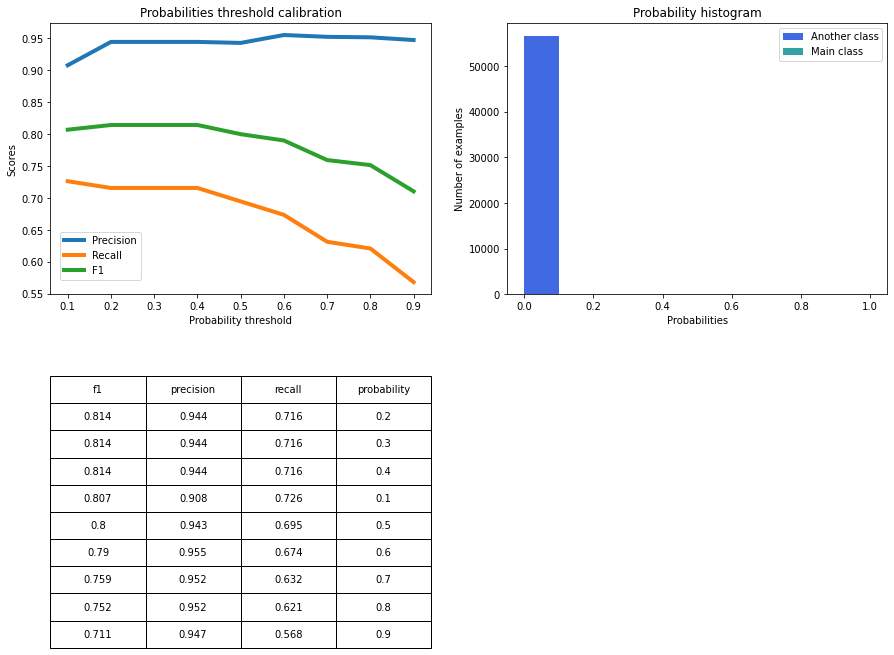

In [22]:
# resutls: too complex model
alpha, k = 0.02, 0.05
lgbm = LGBMClassifier(boosting_type='goss', num_leaves=31, max_depth=8, learning_rate=0.1, n_estimators=250, 
                      min_child_weight=25e-3, subsample=1., colsample_bytree=1., reg_lambda=1e-5, reg_alpha=1e-4, 
                      n_jobs=-1, silent=True, scale_pos_weight=0.199, random_state=1, min_split_gain=0.)
lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False, early_stopping_rounds=10, 
         callbacks=[lightgbm.reset_parameter(learning_rate=lambda current_round: alpha * np.exp(k * current_round))],
         eval_metric='logloss')
l_train_pred = lgbm.predict(X_train)
l_test_pred = lgbm.predict(X_test)
l_train_proba = lgbm.predict_proba(X_train)[:,1]
l_test_proba = lgbm.predict_proba(X_test)[:,1]
report(y_train, l_train_pred, y_test, l_test_pred, l_train_proba, l_test_proba)
# plot_cm_val(y_test, l_test_pred, X_train, y_train, lgbm)
show_proba_calibration_plots(lgbm.predict_proba(X_test)[:, 1], y_test)

In [ ]:
scaler = StandardScaler()
amount = X_train['Amount'].values
amount_test = X_test['Amount'].values
X_train['Amount'] = scaler.fit_transform(amount.reshape(-1, 1))
X_test['Amount'] = scaler.transform(amount_test.reshape(-1,1))

In [24]:
from xgboost import XGBClassifier

In [ ]:
# resutls simple
xg = XGBClassifier(max_depth=4, random_state=1)
xg.fit(X_train, y_train)
x_train_pred = xg.predict(X_train)
x_test_pred = xg.predict(X_test)
report(y_train, x_train_pred, y_test, x_test_pred)

In [ ]:
# try randomUnderSampler -> LGBM / XGBoost

0.05943536404160476

In [ ]:
# custom oversampling
X, y = df.drop(TARGET_NAME, axis=1), df[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=1)
scaler = StandardScaler()
amount = X_train['Amount'].values
amount_test = X_test['Amount'].values
X_train['Amount'] = scaler.fit_transform(amount.reshape(-1, 1))
X_test['Amount'] = scaler.transform(amount_test.reshape(-1,1))

In [ ]:
X_train, y_train = RandomUnderSampler(sampling_strategy=0.15, random_state=1).fit_resample(X_train, y_train)
X_train, y_train = SMOTE(sampling_strategy=0.2, random_state=1).fit_resample(X_train, y_train)

In [ ]:
v1, v2 = y_train.value_counts(normalize=True).get(0), y_train.value_counts(normalize=True).get(1)
v1/v2, v2/v1, y_train.shape

(5.000000000000001, 0.19999999999999998, (3024,))

In [ ]:
from sklearn.cluster import DBSCAN, KMeans

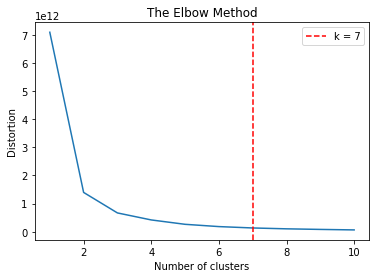

In [ ]:
distortions, silhuettes = [], []
max_k = 10
for i in range(1, max_k + 1):
    if len(X_train) >= i:
        kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=1, tol=1e-04)
        kmeans.fit(X_train)
        distortions.append(kmeans.inertia_)
        if i == 1:
            continue
k = [i*100 for i in np.diff(distortions, 2)].index(min([i*100 for i in np.diff(distortions,2)]))

fig, ax = plt.subplots()
ax.plot(range(1, 11), distortions)
ax.axvline(k, ls='--', color="red", label="k = " + str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', ylabel="Distortion")
plt.legend(loc='best')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=5, max_iter=30, random_state=1, tol=1e-2)
labels_train = kmeans.fit_predict(X_train)
(y_train == labels_train).astype(int).sum(), y_train.value_counts(), np.bincount(labels_train)

(1550, 0    2520
 1     504
 Name: Class, dtype: int64, array([1716, 1308]))

In [26]:
xg = XGBClassifier(n_estimators=800, max_depth=6, min_child_weight=2., gamma=.1, scale_pos_weight=5.2, 
                   colsample=1., colsample_bytree=1., learning_rate=0.1, random_state=1)
xg.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='logloss', early_stopping_rounds=5, verbose=False)
x_train_pred = xg.predict(X_train)
x_test_pred = xg.predict(X_test)
x_train_proba = xg.predict_proba(X_train)[:,1]
x_test_proba = xg.predict_proba(X_test)[:,1]
report(y_train, x_train_pred, y_test, x_test_pred, x_train_proba, x_test_proba)

Train
               precision    recall  f1-score   support

           0      1.000     1.000     1.000    226602
           1      0.984     1.000     0.992       378

    accuracy                          1.000    226980
   macro avg      0.992     1.000     0.996    226980
weighted avg      1.000     1.000     1.000    226980

Test
               precision    recall  f1-score   support

           0      1.000     1.000     1.000     56651
           1      0.934     0.747     0.830        95

    accuracy                          0.999     56746
   macro avg      0.967     0.874     0.915     56746
weighted avg      0.999     0.999     0.999     56746

Train ROC_AUC: 1.000, Test ROC_AUC: 0.964
Train GINI: 1.000, Test GINI: 0.929
Confusion Matrix 
 col_0      0   1
Class           
0      56646   5
1         24  71


In [ ]:
# keras with oversampling and weights, checkpoint, earlystopping, lr_scheduler, initial_bias
# scale data, MinMaxScaler
# add validation split
# metrics ROC, recall, precision

In [27]:
X, y = df.drop(TARGET_NAME, axis=1), df[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, 
                                                      stratify=y_train, random_state=1)

In [28]:
scaler = StandardScaler()  # MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [ ]:
"""
pos = y_train[y_train == 1].astype(int).sum()
neg = y_train.shape[0] - pos
total = X_train.shape[0]
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
"""

In [29]:
buffer_size = 100000
batch_size = 2048

In [30]:
model = tf.keras.Sequential([
                            Dense(256, activation='relu', 
                                  input_shape=(X_train_scaled.shape[-1], ), 
                                  kernel_regularizer=regularizers.l2(0.0001)),
                            Dropout(0.5),
                            Dense(128, activation='relu',
                                  kernel_regularizer=regularizers.l2(0.0001)),
                            Dropout(0.5),
                            Dense(64, activation='relu',
                                  kernel_regularizer=regularizers.l2(0.0001)),
                            Dropout(0.5),
                            Dense(1, activation='sigmoid') #, bias_initializer=output_bias)
])
metrics = [
           tf.keras.metrics.FalseNegatives(name='FN'),
           tf.keras.metrics.FalsePositives(name='FP'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='roc_auc')
]

def lr_(epoch, lr):
    if epoch < 10 or epoch % 2 != 0:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=metrics)

callbacks = [tf.keras.callbacks.ModelCheckpoint('model_epoch_{epoch}.h5'),
             #tf.keras.callbacks.LearningRateScheduler(lr_),
             tf.keras.callbacks.ReduceLROnPlateau(patience=5), # change patience = 5
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               7936      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6

In [31]:
bool_train_labels = y_train != 0
pos_features = X_train_scaled[bool_train_labels]
neg_features = X_train_scaled[~bool_train_labels]
pos_labels = y_train[bool_train_labels]
neg_labels = y_train[~bool_train_labels]

In [ ]:
"""
def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels)).cache()
  ds = ds.shuffle(buffer_size).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)
"""

In [ ]:
"""
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.4, 0.6]) # weights=[0.4, 0.6]
resampled_ds = resampled_ds.batch(batch_size).prefetch(2)
"""

In [ ]:
"""
for features, label in resampled_ds.take(1):
    print(label.numpy().mean())
    print(np.bincount(label.numpy()))
"""

0.38134765625
[1267  781]


In [32]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, int(len(neg_features)*0.4))  # set the sampling_ratio

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels.values[choices]

res_pos_features.shape

(81576, 30)

In [33]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(285518, 30)

In [34]:
np.bincount(resampled_labels)

array([203942,  81576])

In [35]:
pos = resampled_labels[resampled_labels == 1].astype(int).sum()
neg = resampled_labels.shape[0] - pos
total = resampled_features.shape[0]
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 0.6999980386580499, 1: 1.7500122585074043}

In [36]:
resampled_steps_per_epoch = np.ceil((neg+pos)/batch_size)
resampled_steps_per_epoch

140.0

In [37]:
output_layer = model.layers[-1] 
#output_layer.bias.assign([0]) # as if we use balanced dataset
output_bias = tf.keras.initializers.Constant(np.log([pos/neg])) # as if dataset is unbalanced
output_layer.bias_initializer = output_bias

In [ ]:
"""
val_ds = tf.data.Dataset.from_tensor_slices((X_valid_scaled, y_valid)).cache()
val_ds = val_ds.batch(batch_size).prefetch(2) 
"""

In [38]:
train_ds = tf.data.Dataset.from_tensor_slices((resampled_features, resampled_labels)).cache().batch(batch_size).prefetch(0)
val_ds = tf.data.Dataset.from_tensor_slices((X_valid_scaled, y_valid)).cache()
val_ds = val_ds.batch(batch_size).prefetch(2) 

In [39]:
history = model.fit(train_ds, epochs=100, verbose=2, callbacks=callbacks,
                     validation_data=val_ds, class_weight=class_weight, 
                     steps_per_epoch=resampled_steps_per_epoch)

Epoch 1/100
140/140 - 7s - loss: 0.2662 - FN: 7901.0000 - FP: 21596.0000 - precision: 0.7733 - recall: 0.9031 - roc_auc: 0.9651 - val_loss: 0.0915 - val_FN: 1.0000 - val_FP: 484.0000 - val_precision: 0.0710 - val_recall: 0.9737 - val_roc_auc: 0.9990 - lr: 0.0010 - 7s/epoch - 49ms/step
Epoch 2/100
140/140 - 4s - loss: 0.0957 - FN: 2247.0000 - FP: 4672.0000 - precision: 0.9444 - recall: 0.9725 - roc_auc: 0.9974 - val_loss: 0.0661 - val_FN: 1.0000 - val_FP: 309.0000 - val_precision: 0.1069 - val_recall: 0.9737 - val_roc_auc: 0.9979 - lr: 0.0010 - 4s/epoch - 29ms/step
Epoch 3/100
140/140 - 4s - loss: 0.0660 - FN: 676.0000 - FP: 2942.0000 - precision: 0.9649 - recall: 0.9917 - roc_auc: 0.9989 - val_loss: 0.0526 - val_FN: 1.0000 - val_FP: 158.0000 - val_precision: 0.1897 - val_recall: 0.9737 - val_roc_auc: 0.9861 - lr: 0.0010 - 4s/epoch - 30ms/step
Epoch 4/100
140/140 - 4s - loss: 0.0517 - FN: 289.0000 - FP: 1926.0000 - precision: 0.9769 - recall: 0.9965 - roc_auc: 0.9993 - val_loss: 0.0451 

In [43]:
k_pred_train = model.predict(X_train_scaled)
k_pred_test = model.predict(X_test_scaled)

In [50]:
k_train_label = np.where(k_pred_train >= 0.5, 1, 0).flatten()
k_test_label = np.where(k_pred_test >= 0.5, 1, 0).flatten()

In [51]:
report(y_train, k_train_label, y_test, k_test_label, k_pred_train, k_pred_test) # calibrated

Train
               precision    recall  f1-score   support

           0      1.000     1.000     1.000    203942
           1      0.863     1.000     0.926       340

    accuracy                          1.000    204282
   macro avg      0.931     1.000     0.963    204282
weighted avg      1.000     1.000     1.000    204282

Test
               precision    recall  f1-score   support

           0      1.000     1.000     1.000     56651
           1      0.758     0.758     0.758        95

    accuracy                          0.999     56746
   macro avg      0.879     0.879     0.879     56746
weighted avg      0.999     0.999     0.999     56746

Train ROC_AUC: 1.000, Test ROC_AUC: 0.939
Train GINI: 1.000, Test GINI: 0.878
Confusion Matrix 
 col_0      0   1
Class           
0      56628  23
1         23  72


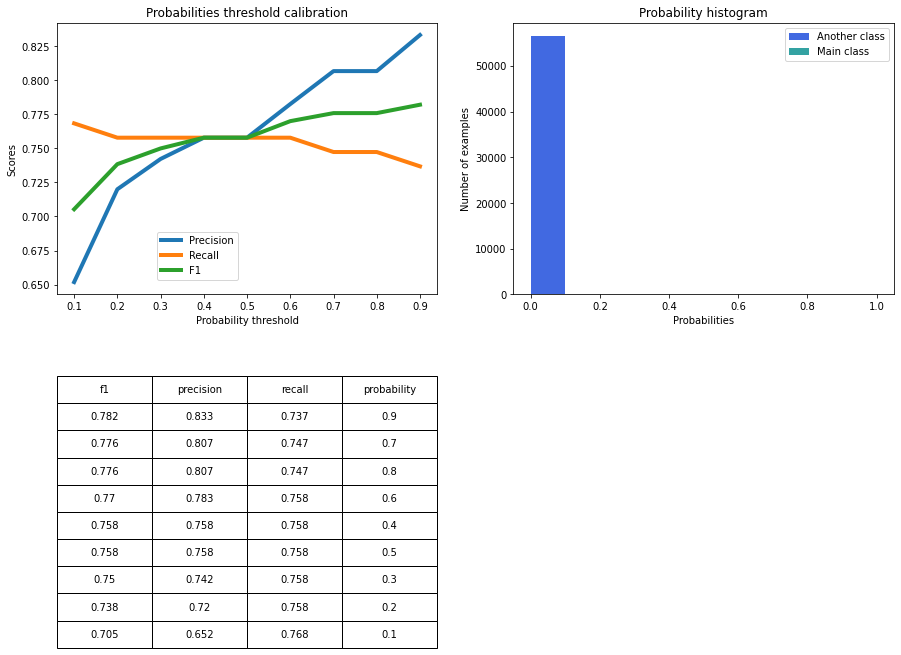

In [47]:
show_proba_calibration_plots(model.predict(X_test_scaled).flatten(), y_test)

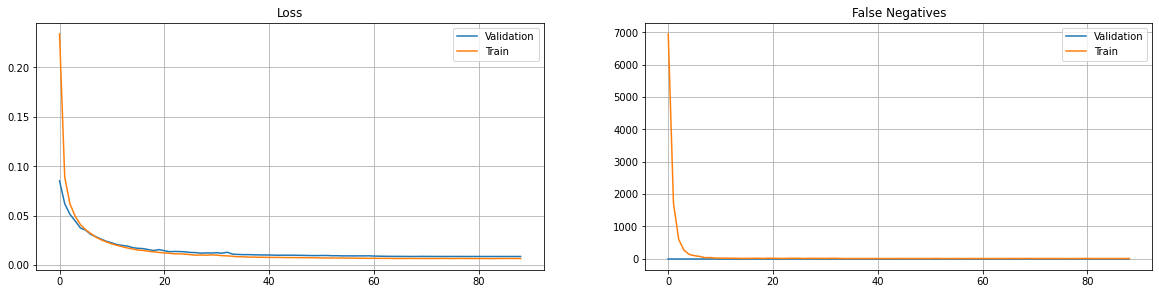

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.title('Loss')
plt.plot(history.history['val_loss'], label='Validation')
plt.plot(history.history['loss'], label='Train')
plt.grid()
plt.legend()
plt.subplot(222)
plt.title('False Negatives')
plt.plot(history.history['val_FN'], label='Validation')
plt.plot(history.history['FN'], label='Train')
plt.legend()
plt.grid()
plt.show()